# Multilayer Perceptron

Previously, [we tried](./02-logistic-regression-word2vec.ipynb) using word embeddings to improve our sentiment classification, but instead of a better score, we got a worse result. That happened because our existing architecture (logistic regression) was unfit for a new vectorization (seemingly much better) approach. But what if we change the architecture itself?

That gives us a nice opportunity to try a different paradigm called **deep learning** - a branch of machine learning and artificial intelligence that uses artificial neural networks to process data and learn patterns. These networks, inspired by the structure of the human brain, are built with multiple layers of interconnected **neurons** that allow them to identify complex relationships and make predictions. 

##  Data Preparation

In [1]:
from datasets import load_dataset
ds = load_dataset('stanfordnlp/imdb', split='train+test')
train, test = ds.train_test_split(test_size=0.2, seed=0).values()
display(train.to_pandas())

x_train = train['text']
y_train = train['label']
x_test = test['text']
y_test = test['label']

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,text,label
0,After the SuperFriends and Scooby Doo left the...,1
1,good job.that's how i would describe this anim...,1
2,Michael Cacoyannis has had a relatively long c...,1
3,I've just seen this film in a lovely air-condi...,0
4,My one-line summary hints that this is not a g...,1
...,...,...
39995,***SPOILERS*** ***SPOILERS*** After two so-so ...,1
39996,"Way back in 1967, a certain director had no id...",0
39997,I saw this movie with my dad. I must have been...,1
39998,During my teens or should I say prime time I w...,1


Our vectorization routine remains exactly the same. We are doing this to see how the change in *approach* affects the final result without touching any preparational routines.

In [2]:
import numpy as np
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from huggingface_hub import snapshot_download
from os import path

model_path = path.join(snapshot_download('fse/word2vec-google-news-300'), 'word2vec-google-news-300.model')
wv = KeyedVectors.load(model_path)

def vectorize(text):
    tokens = simple_preprocess(text.lower(), deacc=True)
    token_vectors = [wv.get_vector(x) for x in tokens if x in wv]
    if token_vectors:
        return np.mean(token_vectors, axis=0)
    else:
        return np.zeros(wv.vector_size)

Fetching 4 files: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 39107.73it/s]


## Data Encoding

Before we proceed further, we need to transform our data. That happens because neural networks do not work with textual information *directly* - instead, we need to encode our data, turning them into some kind of mathematical representation.

In [3]:
x_train = np.array([vectorize(seq) for seq in x_train])
x_test = np.array([vectorize(seq) for seq in x_test])

Labels need to be encoded to. To do this, we may utilise a technique called **one-hot encoding** - it encodes each category as a binary vector where only one element is **hot** (1) and all others are **cold** (0).

In [4]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=len(ds.features['label'].names))
y_test = to_categorical(y_test, num_classes=len(ds.features['label'].names))
display(y_train)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

## Building and Training the Model

Now, let's design our model structure. This time, we will use a thing called **multilayer perceptron**. As its name states, it is a neural network that consists of multiple **layers** of neurons - allowing one to learn complex, non-linear relationships in data (unlike linear regression classifier).

For this task, we will use three types of layers:

- **Input**: Transforms our source data and passes it next.
- **Dense**: Layer of densely connected neurons (each neuron is connected to all other neurons of the neighboring layers).
- **Dropuput**: Special normalization layer that helps against overfitting by randomly disabling parts of the previous layer during the training process.

We may experiment with number of hidden layers and dropout rates - those are, in fact, hyperplanar parameters that may be tuned. Stack more layers meme, you know.

In [5]:
from keras.utils import set_random_seed
from keras import layers, Sequential

num_classes = len(ds.features['label'].names)
set_random_seed(0)

model = Sequential([
    layers.Input(shape=(wv.vector_size,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.50),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='softmax')
])

display(model.summary())

W0000 00:00:1750195123.939046 34041439 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1750195123.963507 34041439 service.cc:145] XLA service 0x600002d7e500 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750195123.963653 34041439 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1750195123.965406 34041439 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1750195123.965420 34041439 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,154 (817.01 KB)

 Trainable params: 209,154 (817.01 KB)

 Non-trainable params: 0 (0.00 B)

None

We can compile and train our model now. Sticking to the CPU may be a good idea for now - using GPU for such a small model may actually slow down the training process due to a huge data transfer overhead.

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=75, batch_size=64, validation_split=0.2) 

Epoch 1/75


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float32[300,256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256,2]), ShapedArray(float32[2]), ShapedArray(uint32[2]), ShapedArray(uint32[2]), ShapedArray(uint32[2]), ShapedArray(int32[]), ShapedArray(float32[]), ShapedArray(float32[300,256]), ShapedArray(float32[300,256]), ShapedArray(float32[256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256]), ShapedArray(float32[256,2]), ShapedArray(float32[256,2]), ShapedArray(float32[2]), ShapedArray(float32[2]), ShapedArray(float32[]), ShapedArray(

494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7175 - loss: 0.5274

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float32[300,256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256,2]), ShapedArray(float32[2]), ShapedArray(uint32[2]), ShapedArray(uint32[2]), ShapedArray(uint32[2]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[]).
Donation is not implemented for ('METAL',).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7185 - loss: 0.5263 - val_accuracy: 0.8311 - val_loss: 0.3843
Epoch 2/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8317 - loss: 0.3843 - val_accuracy: 0.8474 - val_loss: 0.3561
Epoch 3/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8393 - loss: 0.3722 - val_accuracy: 0.8450 - val_loss: 0.3533
Epoch 4/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8417 - loss: 0.3626 - val_accuracy: 0.8555 - val_loss: 0.3426
Epoch 5/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8416 - loss: 0.3625 - val_accuracy: 0.8421 - val_loss: 0.3551
Epoch 6/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8490 - loss: 0.3531 - val_accuracy: 0.8590 - val_loss: 0.3435
Epoch 7/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8480 - loss: 0.3539 - val_accuracy: 0.8394 - val_loss: 0.3579
Epoch 8/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8509 - loss: 0.3518 - val_accuracy: 0.8468 - val_

## Result

In [7]:
from sklearn.metrics import classification_report
y_pred_probs = model.predict(x_test, verbose=False)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels, target_names=ds.features['label'].names))

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float32[300,256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256,256]), ShapedArray(float32[256]), ShapedArray(float32[256,2]), ShapedArray(float32[2]), ShapedArray(uint32[2]), ShapedArray(uint32[2]), ShapedArray(uint32[2]).
Donation is not implemented for ('METAL',).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


              precision    recall  f1-score   support

         neg       0.85      0.88      0.87      5025
         pos       0.88      0.85      0.86      4975

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



Let's take a look at the training history - it may tell us *a lot*.

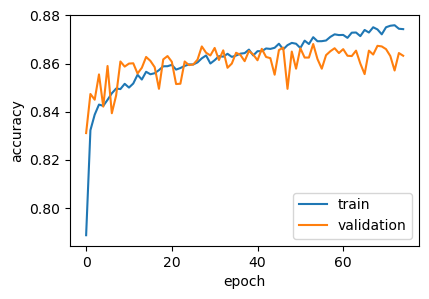

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

We can observe that the training accuracy steadily increases, indicating the model is continuously learning from the training data. However, the validation accuracy shows a different trend - it rises initially but then begins to plateau around epoch 50-60, stabilizing at approximately 86-87%. 

The widening gap between the training and validation accuracy in later epochs is a classic sign of **overfitting**, where the model becomes too specialized in the training examples, essentially memorizing them. To mitigate this, we might need more training data, or a better model architecture.

## Conclusion

This experiment yielded an **~87%** accuracy, confirming that a deeper, non-linear model can extract more a bit more signal from these embeddings than a linear classifier. The addition of hidden layers and dropout underscores the "stack more layers" principle, at least to a point.

While being a slight improvement, it still trails our original n-gram model. This suggests that to fully leverage semantic richness, architectures capable of processing sequences are the necessary next step.